# COM calculation
## Load all tiffs in scan folder, average, plot centre of mass of residuals in 2D

In [67]:
import tifffile as tif
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import center_of_mass as com
from scipy.optimize import curve_fit
import os
from scipy.signal import detrend
import scipy.io as sio
from tqdm import tqdm_notebook
from scipy.stats import norm
import matplotlib.mlab as mlab
from mda import *

In [174]:
%matplotlib inline

#Needs to follow inline magick command
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 28
plt.rcParams['image.cmap'] = 'viridis'

## Change following variables as required

In [330]:
imgsperpt=1 #Acquisitions per scan point

scan_number=114
path='/CNMshare/savedata/2018R3/20181002/'#Scan path
#path = '%d/' %scan_number

#ROI of data you want to analyze
roix1=165
roix2=roix1+340
roiy1=165
roiy2=roiy1+182

detx,dety=512,512

save_figs_yes_no = 1 #Save 2D maps and/or histograms?
sav_figs_path = '/Users/user26id/Desktop/saidur_images_data' #Where to save images

## Get scan dimensions and detector distance from mda file

In [331]:
dataf=readMDA(path+'mda/26idbSOFT_%04d' %scan_number, showHelp=0)
Ypts=dataf[1].p[0].data
Ypts=np.asarray(Ypts)
Xpts=dataf[2].p[0].data
Xpts=np.asarray(Xpts[0])

ny, nx= Ypts.shape[0],Xpts.shape[0] #Scan dimensions

delY=(Ypts[-1]-Ypts[0])/(ny-1)*1000 # in nm
delX=(Xpts[-1]-Xpts[0])/(nx-1)*1000 # in nm

delY=int(delY) #Assuming you would never need sub-nm resolution
delX=int(delX) 

### Find detector distance channel number

In [332]:
det_dist = 875 #Default if not recorded as part of scan
for i in range(len(dataf[2].d)):
    if (b'robot:R_d' in dataf[2].d[i].name): 
        print ("Detector distance found in scan record", dataf[2].d[i].name)
        det_dist = int(dataf[2].d[i].data[0][0])
        print ("Detector distance is %d mm" %det_dist)

mrads = 55e-3/det_dist*1000.0 ##Det distance is in mm

Detector distance found in scan record b'26idcDET:robot:R_d'
Detector distance is 875 mm


In [333]:
print (ny,delY)
print (nx,delX)
print (det_dist)

101 14
101 15
875


### Read all tiff files

In [334]:
files=sorted(os.listdir(path+'Images/%d' %scan_number))
nfiles=len(files)
npts=ny*nx
#npts=1000
print ("Npts", npts)


data=np.zeros((npts,roiy2-roiy1,roix2-roix1),float)
i,j=0,0
for fl in tqdm_notebook(files):
    data[i,:,:]=tif.imread(path+'Images/%d/' %scan_number +fl)[roiy1:roiy2,roix1:roix2]
    j+=1
    if(j%imgsperpt==0): i+=1
    if(i>=npts): break
print (i,j, data.shape)

Npts 10201


10201 10201 (10201, 182, 340)


## Plot average intensity and ith frame

In [335]:
avg_intens=np.average(data, axis=0)

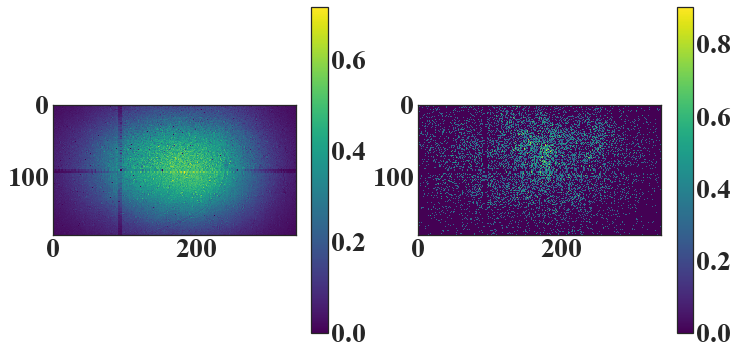

In [336]:
i=0
figs,ax=plt.subplots(1,2,figsize=(12,6))
im=ax[0].imshow(np.log10(avg_intens+1))
plt.colorbar(im,ax=ax[0])
im=ax[1].imshow(np.log10(data[0]+1))
plt.colorbar(im,ax=ax[1])

## Subtract average detector image from each frame

In [337]:
data2=data-avg_intens
data2=data

## Plot data after subtracting average from each frame

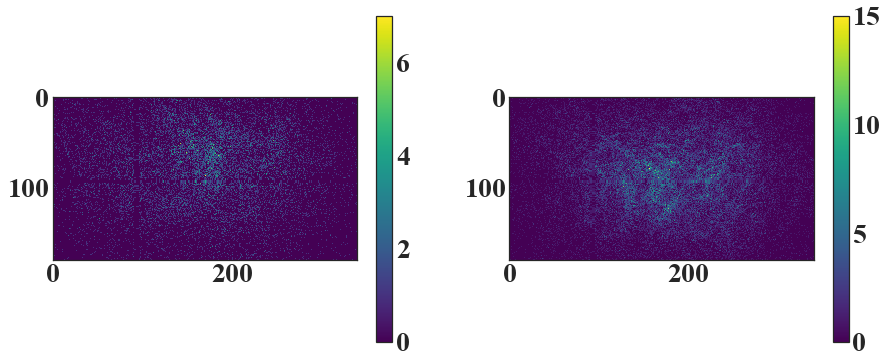

In [338]:
i,j=0,400
figs,ax=plt.subplots(1,2,figsize=(15,6))
im=ax[0].imshow(data2[i])
plt.colorbar(im,ax=ax[0])
im=ax[1].imshow(data2[j])
plt.colorbar(im,ax=ax[1])

## Calculate centre of masses, subtract the COM of the average image
### All centroid shift is now relative to average

In [339]:
use_subtracted_data=1 #Whether to use frame (minus) average data or not
n_max_allow = 500 #Ignore points where max counts > some value --- bad, bright detector images

In [340]:
coms=np.zeros((npts,2),float)
bad_frames=[]
for i in range(npts):
    if(data[i,:,:].max()>n_max_allow):
        print('Frame %d is too bright' %(i+1))
        bad_frames.append(i)
        
    elif(not data[i,:,:].any()>0):
        print('Frame %d is all 0' %(i+1))
        bad_frames.append(i)
        
    else:
        if(use_subtracted_data): coms[i,:]=np.asarray(com(data2[i,:,:]))
        else: coms[i,:]=np.asarray(com(data[i,:,:]))


print (coms[0], coms[400])
#coms-=coms[0,:]

#Set COM of missing frames to the average
for i in bad_frames:
    coms[i,0], coms[i,1]= np.average(coms[:,0]), np.average(coms[:,1])

print ("Average COMs:", np.average(coms[:,0]), np.average(coms[:,1]))

print ("Max COMs:", np.max(coms[:,0]), np.max(coms[:,1]))
    
#Move average COM shift to 0
for i in range (2):
    coms[:,i]-=np.average(coms[:,i])

print (coms[0], coms[400])

[ 78.6273621  167.89011469] [ 88.6560545  177.98461082]
Average COMs: 88.47431083602814 173.09976549675437
Max COMs: 118.52826518381703 214.92529991743163
[-9.84694874 -5.20965081] [0.18174367 4.88484532]


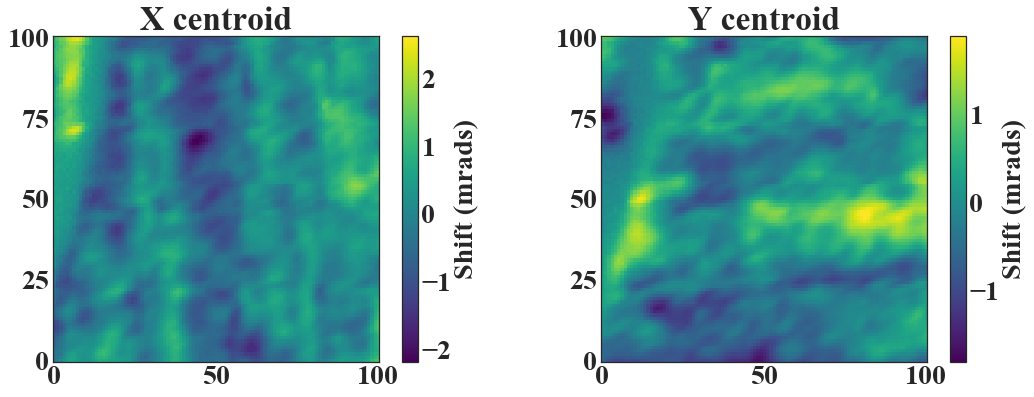

In [341]:
coms=coms.reshape(ny,nx,2)
figs,ax=plt.subplots(1,2,figsize=(18,6))
im=ax[0].imshow(coms[:,:,1]*mrads, origin='lower') #CAREFUL: Rows is Y
cb=plt.colorbar(im,ax=ax[0])
ax[0].set_title("X centroid")
cb.set_label("Shift (mrads)")

im=ax[1].imshow(coms[:,:,0]*mrads, origin='lower')
cb=plt.colorbar(im,ax=ax[1])
ax[1].set_title("Y centroid")
cb.set_label("Shift (mrads)")

if(save_figs_yes_no):
    plt.savefig('%s/%d_maps.png' %(sav_figs_path,scan_number), dpi=300)

## Detrend and plot if so required

In [342]:

#tmp2=detrend(coms[:,:,1], axis=0)
#im=ax[1].imshow(tmp2)
#plt.colorbar(im,ax=ax[1])
#ax[1].set_title("Detrended")
#sio.savemat('raw_data.mat', {'data':data})

### Calculate shift magnitude and shift angle
Assuming X centroid shift is only due to curvature (True if the rocking curve is very broad)

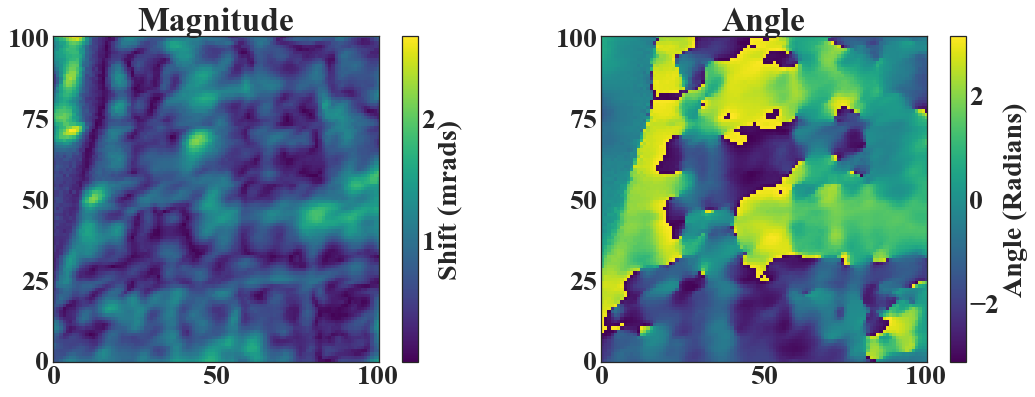

In [343]:
mags = (coms[:,:,0]**2+coms[:,:,1]**2)**0.5
angles = np.arctan2(coms[:,:,0],coms[:,:,1])

figs,ax=plt.subplots(1,2,figsize=(18,6))
im=ax[0].imshow(mags*mrads, origin='lower') #CAREFUL: Rows is Y
cb=plt.colorbar(im,ax=ax[0])
ax[0].set_title("Magnitude")
cb.set_label("Shift (mrads)")

im=ax[1].imshow(angles, origin='lower')
cb=plt.colorbar(im,ax=ax[1])
ax[1].set_title("Angle")
cb.set_label("Angle (Radians)")

if(save_figs_yes_no):
    plt.savefig('%s/%d_mag_maps.png' %(sav_figs_path,scan_number), dpi=300)

In [344]:
np.max(angles)-np.min(angles)

6.281045621210978

## Plot heatmap of curvature with arrows to show the vector field

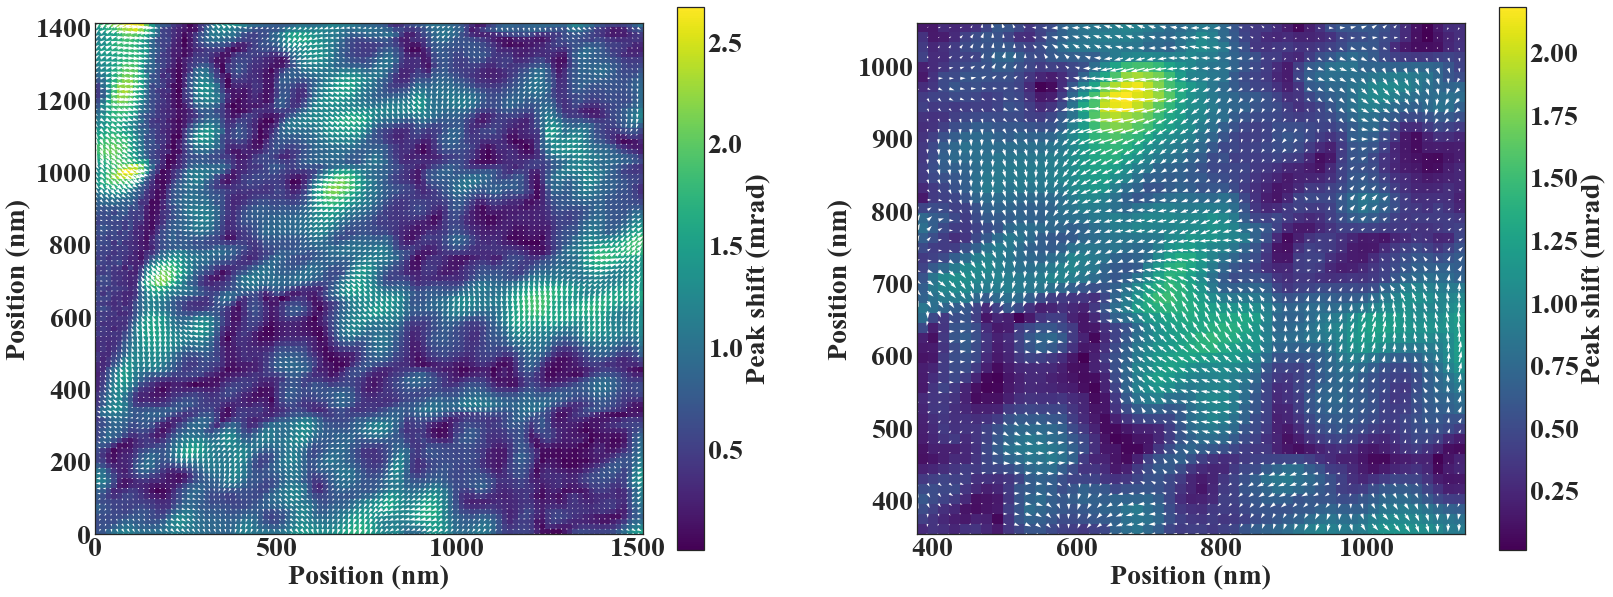

In [345]:
extents1=[0, nx*delX,0, ny*delY]
fig, ax = plt.subplots(1,2,figsize=(27,10))

x = np.arange(0, nx*delX, delX)
y = np.arange(0, ny*delY, delY)
X,Y = np.meshgrid(x,y)
im=ax[0].imshow(mags*mrads, origin='lower', extent=extents1) #CAREFUL: Rows is Y
q = ax[0].quiver(X, Y, coms[:,:,1], coms[:,:,0], color='white')#, scale=400)
cb=plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("Position (nm)")
ax[0].set_ylabel("Position (nm)")
cb.set_label("Peak shift (mrad)")

extents2=[nx/4*delX, 3*nx/4*delX,ny/4*delY, 3*ny/4*delY]
x = np.arange(nx/4*delX, 3*nx/4*delX, delX)
y = np.arange(ny/4*delY, 3*ny/4*delY, delY)
X,Y = np.meshgrid(x,y)
im=ax[1].imshow(mags[int(ny/4):int(-ny/4),int(nx/4):int(-nx/4)]*mrads, origin='lower', extent=extents2) #CAREFUL: Rows is Y
q = ax[1].quiver(X, Y, coms[int(ny/4):int(-ny/4),int(nx/4):int(-nx/4),1], coms[int(ny/4):int(-ny/4),int(nx/4):int(-nx/4),0], color='white')#, scale=400)
cb=plt.colorbar(im,ax=ax[1])
ax[1].set_xlabel("Position (nm)")
ax[1].set_ylabel("Position (nm)")
cb.set_label("Peak shift (mrad)")

if(save_figs_yes_no):
    plt.savefig('%s/%d_quiver_maps.png' %(sav_figs_path,scan_number), dpi=400)

8.302783462660909e-16 0.6153306686054908


/Users/user26id/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


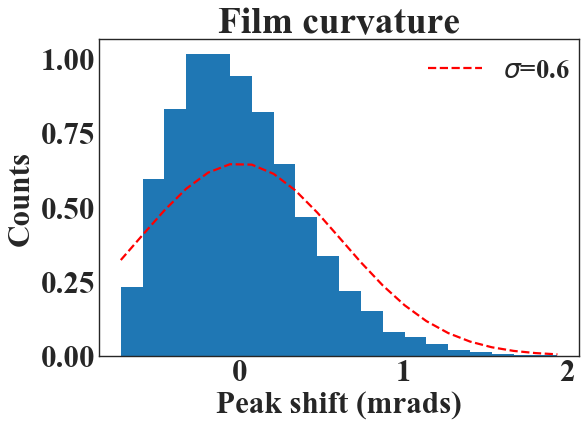

In [346]:
(mu, sigma) = norm.fit((coms[:,:,1]*mrads).ravel())
print (mu, sigma)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

#n, bins, patches=plt.hist(coms[:,:,0].ravel(), bins=20, density=1)
n, bins, patches=plt.hist((mags*mrads).ravel()-np.mean(mags*mrads), bins=20, density=1)

y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2, label=r'$\sigma$=%.1f' %sigma)

plt.xlabel("Peak shift (mrads)")
plt.ylabel("Counts")
plt.title("Film curvature")
plt.legend(loc='right', bbox_to_anchor=(1.03, 0.9), fontsize=24)
plt.tight_layout()
if(save_figs_yes_no):
    plt.savefig('%s/%d_hist.png' %(sav_figs_path,scan_number), dpi=300)

### Save histogram to txt file

In [347]:
data = np.vstack((bins[:-1],n))
data = data.T

if(save_figs_yes_no):
    np.savetxt('%s/scan_%d_hist.csv' %(sav_figs_path,scan_number), data, delimiter=',')
    np.savetxt('%s/scan_%d_mags.csv' %(sav_figs_path,scan_number), mags, delimiter=',')
    np.savetxt('%s/scan_%d_angle.csv' %(sav_figs_path,scan_number), angles, delimiter=',')
    np.savetxt('%s/scan_%d_Y_centroid.csv' %(sav_figs_path,scan_number), coms[:,:,1], delimiter=',')
    np.savetxt('%s/scan_%d_X_centroid.csv' %(sav_figs_path,scan_number), coms[:,:,0], delimiter=',')